# Reinforcement Learning

**Reinforcement learning (RL)** is a type of machine learning where 
- An **agent** learns to make decisions by interacting with an **environment**.
- The agent receives feedback in the form of **rewards** or **penalties** based on its actions,
- and its goal is to **learn a policy** (a strategy) that maximizes cumulative rewards over time.

The agent explores different actions, observes the outcomes, and gradually improves its decision-making process through trial and error. 

Unlike supervised learning, where the model learns from labeled examples, reinforcement learning is about **learning from the consequences of actions**.

*In Simple Terms:
Reinforcement learning is like teaching a robot to play a game. The robot (agent) doesn't know the rules at the beginning but learns by playing the game (interacting with the environment). Each time it wins or makes progress (gets a reward), it tries to remember what actions led to success. If it makes a mistake or loses (gets a penalty), it avoids doing the same thing in the future. Over time, the robot learns the best strategies to win.*

In the context of finance, reinforcement learning can be used to create intelligent agents that make decisions about trading, portfolio management, or risk management. For example:

- **Algorithmic Trading**: An RL agent could learn how to buy and sell stocks by experimenting with different strategies in a simulated market. The goal is to maximize returns while minimizing risks by learning the best times to execute trades based on historical data, price movements, and market conditions.
- **Portfolio Optimization**: In portfolio management, an RL agent could learn how to allocate assets dynamically to maximize the return on investment while balancing risks, learning from market fluctuations and feedback from the financial performance of the portfolio.
- **Risk Management**: An RL-based system could be used to manage financial risks by learning from historical market data and adjusting strategies to avoid significant losses during market downturns.

In finance, RL is particularly valuable because it allows models to adapt to changing market conditions, optimizing decisions in complex environments where the optimal strategies are not always obvious or static.

## Reinforcement learning (RL) example
We will set up and implement a simple reinforcement learning (RL) example. We'll develop an RL agent that learns to trade a single stock to maximize profit in a simulated market environment.

Overview:
- Environment: Simulated stock price using a geometric Brownian motion.
- Agent Actions: Buy, Sell, or Hold.
- Objective: Maximize cumulative profit over a trading episode.
- Algorithm: Q-learning (a basic RL algorithm).

## Step 0: Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Simulate Stock Prices

We simulate stock prices using Geometric Brownian Motion (GBM), a commonly used model in finance to represent stock price movements.

In [35]:
def generate_stock_prices(S0, mu, sigma, n_steps):
    dt = 1 / n_steps
    prices = [S0]
    for _ in range(n_steps - 1):
        S_t = prices[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.randn())
        prices.append(S_t)
    return np.array(prices)

# Parameters
S0 = 100                   # Initial stock price
mu = 0.05/252              # Drift: 5% annual increase converted to daily scale
sigma = 0.2 /np.sqrt(252)  # Volatility: 20% annual volatility converted to daily scale
n_steps = 200              # Number of time steps (days)

prices = generate_stock_prices(S0, mu, sigma, n_steps)

At each time step, the stock price is being updated using the [GBM formula](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) with the following parameters:

- $S0$: Initial stock price (e.g., $\$100$).
- $\mu$ (mu): Drift coefficient representing the expected return.
- $\sigma$ (sigma): Volatility coefficient representing the stock's volatility.
- `n_steps`: Total number of time steps in the simulation.



## Step 2: Define the Trading Environment

We need to define the **state** and the **rewards**.

- **State** representation: Current stock price. The agent observes the current stock price as the state.
- **Actions**: 0 (Hold, do nothing), 1 (Buy one share ), 2 (Sell one share if holdings >0).
- **Reward**: Change in portfolio value. The reward is the profit (or loss) relative to the initial capital ($\$10,000$).

Environment Mechanics:
- Holdings: Number of shares the agent currently owns.
- Cash: Available cash balance.
- Portfolio Value: Sum of cash and the market value of holdings.

Reset Function (reset):
- Initializes or resets the environment to the starting state.

Step Function (step):
- Executes the action, updates the environment state, and computes the reward.
- Determines if the episode (trading period) is done.

In [39]:
class TradingEnvironment:
    def __init__(self, prices):
        self.prices = prices
        self.n_steps = len(prices)
        self.reset()
        
    def reset(self):
        self.current_step = 0
        self.holdings = 0  # Number of shares held
        self.cash = 10000  # Starting with $10,000
        self.portfolio_value = self.cash
        return self._get_state()
    
    def _get_state(self):
        return self.prices[self.current_step]
    
    def step(self, action):
        price = self.prices[self.current_step]
        done = False
        
        # Action: 0 = Hold, 1 = Buy, 2 = Sell
        if action == 1:  # Buy one share
            self.cash -= price
            self.holdings += 1
        elif action == 2 and self.holdings > 0:  # Sell one share
            self.cash += price
            self.holdings -= 1
        
        self.current_step += 1
        if self.current_step >= self.n_steps - 1:
            done = True
            
        self.portfolio_value = self.cash + self.holdings * price
        reward = self.portfolio_value - 10000  # Profit since start
        
        next_state = self._get_state() if not done else None
        return next_state, reward, done

## Step 3: Implement Q-learning Agent

We'll create a simple Q-table where states are discretized stock prices.

**Q-table Initialization**:
- An 2D array (basically a table) where rows represent states and columns represent actions.
- Stores Q-values $Q\left(s,a\right)$ for each state-action pair.

**Hyperparameters** (choices that you need to make/decide):
- Epsilon ($\epsilon$): Exploration rate (probability of choosing a random action).
- Alpha ($\alpha$): Learning rate (how much new information overrides old information).
    - Range: $0<\alpha\leq 1$
    - $\alpha$ close to 0: Slow learning; new information has little impact.
    - $\alpha$ close to 1: Fast learning; new information replaces old estimates quickly.
- Gamma ($\gamma$): Discount factor (importance of future rewards).
    - Range: $0\leq\gamma\leq 1$
    - $\gamma$ close to 0: Agent considers only immediate rewards.
    - $\gamma$ close to 1: Agent values future rewards more significantly.

**State Discretization**
- Since stock prices are continuous, we discretize them to reduce the state space.
- Simplifies the continuous stock price by converting it to an integer.
- Example: A stock price of $102.75 becomes state 102.

**Action Selection Policy**
- `choose_action`: note that `np.random.randint(0, 3)` code randomly selects an integer value, 0,1, or 2, these are our actions (hold, buy, sell).
- So, the way it works, if you set $\epsilon=0.1$, then with probability 10%, the code selects a random action to explore new possibilities. This is called **exploration**.
- With probability 90% ($1-\epsilon=0.9$), select the action with the highest Q-value for the current state. This is called **exploitation**.
- This is called an **epsilon-greedy policy**.

In [42]:
class QLearningAgent:
    def __init__(self, state_space, action_space, epsilon=0.1, alpha=0.2, gamma=0.9):
        self.q_table = np.zeros((state_space, action_space))
        self.epsilon = epsilon  # Exploration rate
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        
    def discretize(self, state):
        return int(state // 1)  # Simple discretization
    
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 3)  # Explore
        else:
            state = self.discretize(state)
            return np.argmax(self.q_table[state])  # Exploit
        
    def learn(self, state, action, reward, next_state, done):
        state = self.discretize(state)
        next_state = self.discretize(next_state) if next_state is not None else 0
        predict = self.q_table[state, action]
        target = reward if done else reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.alpha * (target - predict)


## Step 4: Train the Agent

**Episodes**: (in this case 100, but you can change it) Each episode represents a complete trading period over the simulated stock prices.

**Steps within an Episode**:
- State Observation: Agent observes the current stock price.
- Action Selection: Agent selects an action using the epsilon-greedy policy.
- Environment Step: The environment updates based on the action and returns the next state, reward, and whether the episode is done.
- Learning Update: Agent updates its Q-table using the learn function.
- State Transition: The agent moves to the next state.

**Agent's Learning Over Time**
- Exploration vs. Exploitation:
    - Initially, the agent explores the environment by taking random actions.
    - Over time, as Q-values get updated, the agent exploits learned strategies more often.
- Q-table Convergence:
    - The Q-table values converge towards the true expected rewards for state-action pairs.
    - The agent learns which actions yield higher rewards in specific states.

In [45]:
env = TradingEnvironment(prices)
agent = QLearningAgent(state_space=200, action_space=3, epsilon=0.1, alpha=0.2, gamma=0.9)

episodes = 100
portfolio_values = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward = reward
    portfolio_values.append(env.portfolio_value)
    print(f"Episode {episode + 1}/{episodes}, Portfolio Value: {env.portfolio_value:.2f}")


Episode 1/100, Portfolio Value: 10000.30
Episode 2/100, Portfolio Value: 10020.25
Episode 3/100, Portfolio Value: 9999.76
Episode 4/100, Portfolio Value: 10001.50
Episode 5/100, Portfolio Value: 10002.77
Episode 6/100, Portfolio Value: 10002.30
Episode 7/100, Portfolio Value: 10010.03
Episode 8/100, Portfolio Value: 10000.30
Episode 9/100, Portfolio Value: 10003.08
Episode 10/100, Portfolio Value: 10046.79
Episode 11/100, Portfolio Value: 10048.72
Episode 12/100, Portfolio Value: 10044.10
Episode 13/100, Portfolio Value: 10011.21
Episode 14/100, Portfolio Value: 10026.52
Episode 15/100, Portfolio Value: 10015.25
Episode 16/100, Portfolio Value: 10044.92
Episode 17/100, Portfolio Value: 10018.59
Episode 18/100, Portfolio Value: 10000.20
Episode 19/100, Portfolio Value: 9988.34
Episode 20/100, Portfolio Value: 10020.13
Episode 21/100, Portfolio Value: 10007.39
Episode 22/100, Portfolio Value: 10038.68
Episode 23/100, Portfolio Value: 9996.77
Episode 24/100, Portfolio Value: 10017.25
Epis

## Step 5: Visualize the Results

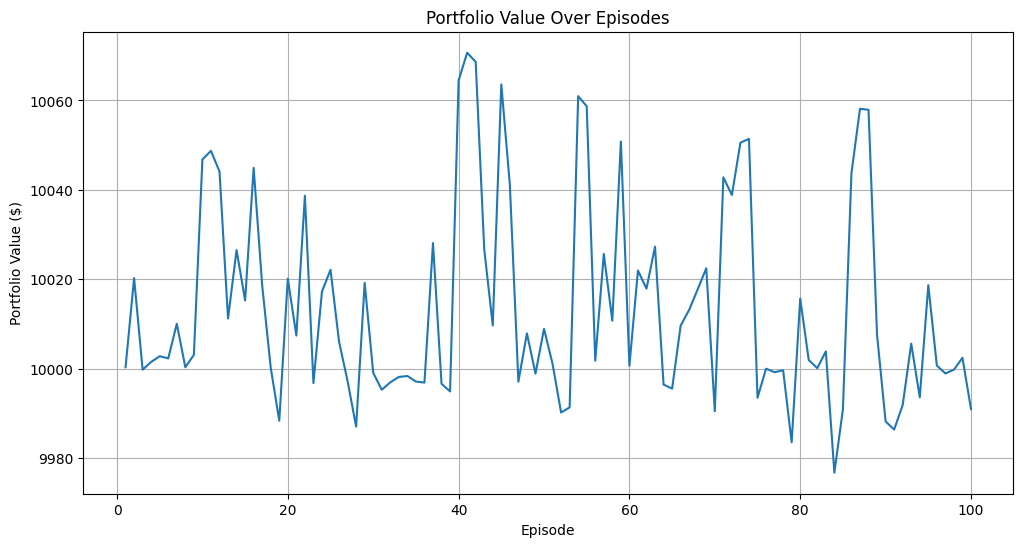

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, episodes + 1), portfolio_values)
plt.title('Portfolio Value Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()


## Step 6: Analyze the Trading Strategy

Let's see how the agent performed in the last episode.

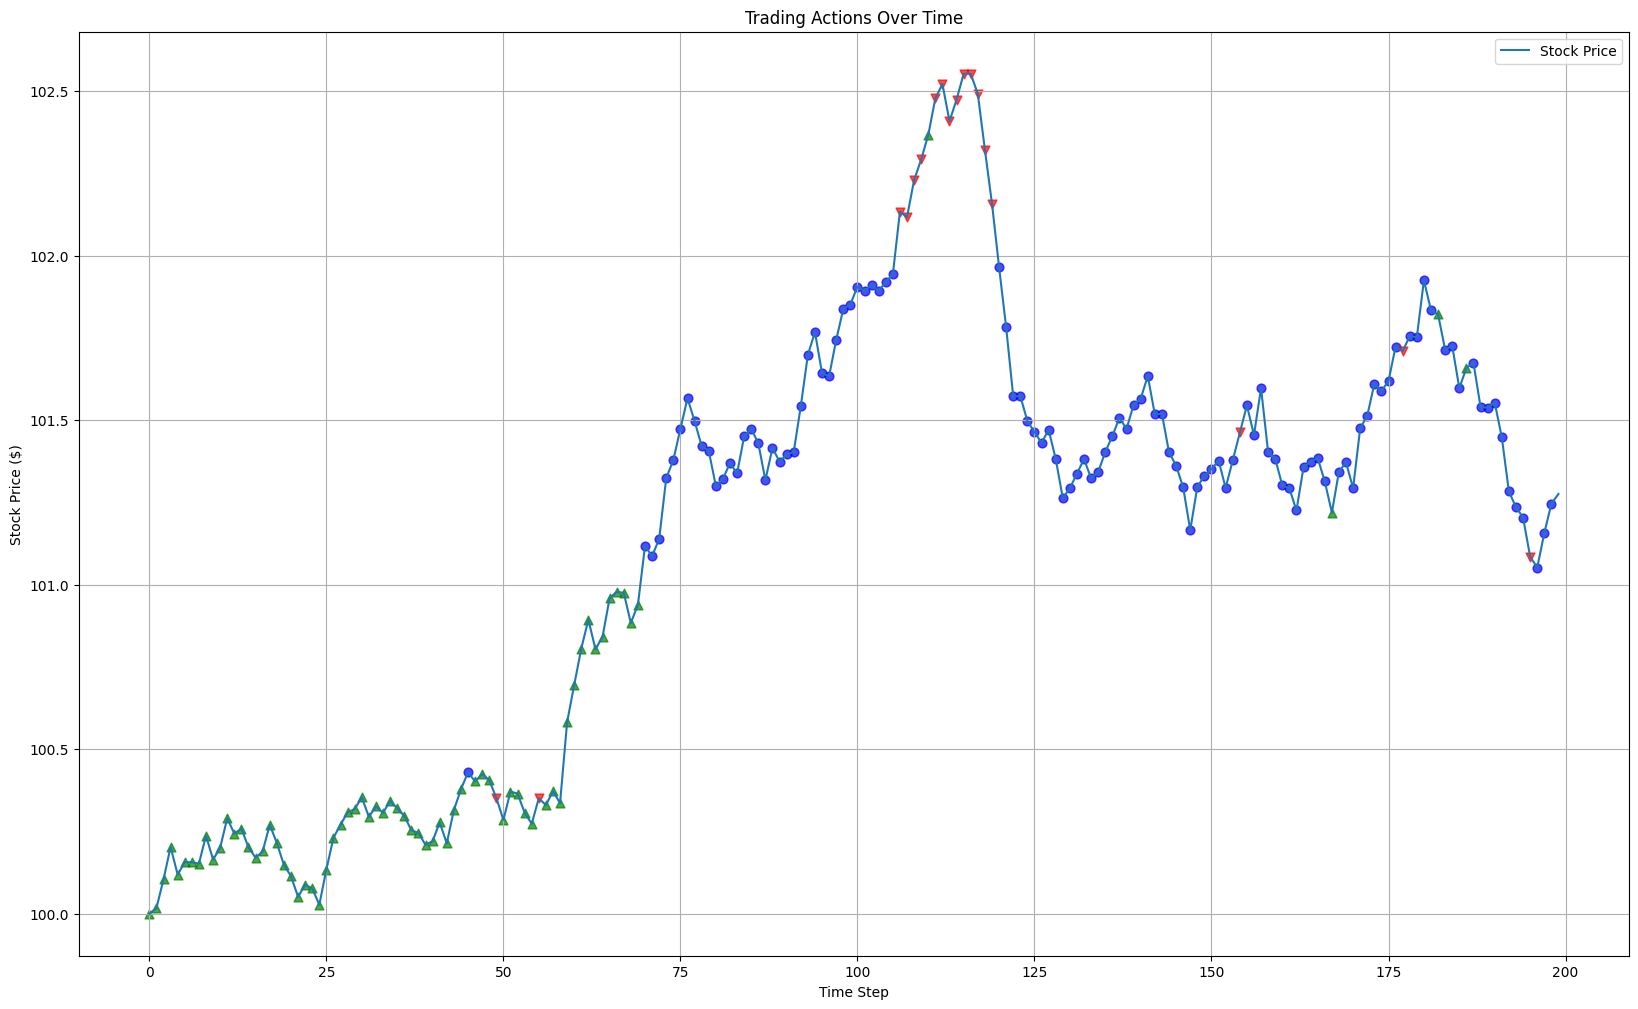

In [51]:
# Re-run the last episode to collect data
state = env.reset()
states = []
actions = []
portfolio_values = []
done = False
while not done:
    action = agent.choose_action(state)
    actions.append(action)
    states.append(state)
    next_state, reward, done = env.step(action)
    portfolio_values.append(env.portfolio_value)
    state = next_state

# Plot the actions taken over time
action_names = ['Hold', 'Buy', 'Sell']
action_colors = ['blue', 'green', 'red']
action_markers = ['o', '^', 'v']
action_alphas = [0.7, 0.7, 0.7]  # Set alpha values for each action

plt.figure(figsize=(20, 12))
plt.plot(prices, label='Stock Price')
for idx, (action, price) in enumerate(zip(actions, prices[:len(actions)])):
    alpha = action_alphas[action]
    plt.scatter(idx, price, 
                color=action_colors[action], 
                marker=action_markers[action], 
                s=40, 
                alpha=alpha)
plt.title('Trading Actions Over Time')
plt.xlabel('Time Step')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.show()


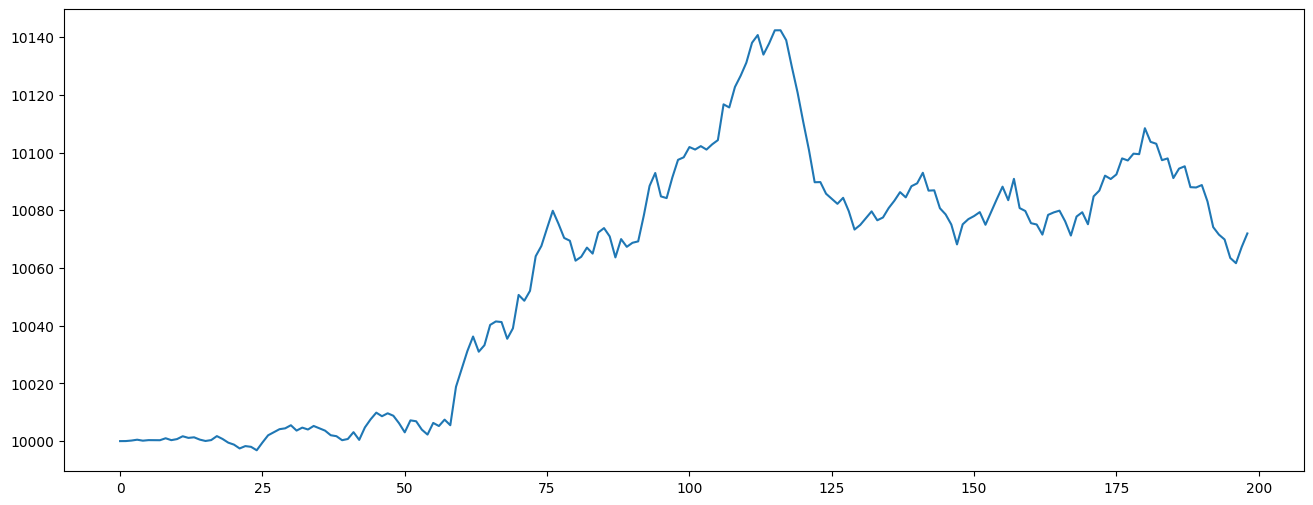

In [53]:
plt.figure(figsize=(16, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.show()

## Conclusion: Visualization of Result

1. The first subplot displays the **stock price over time** with markers indicating the actions taken (Buy, Sell, Hold).
2. The second subplot shows how the **portfolio value** changes over the same time steps.

Since both plots share the $x$-axis, you can easily correlate the trading actions with changes in the portfolio value.

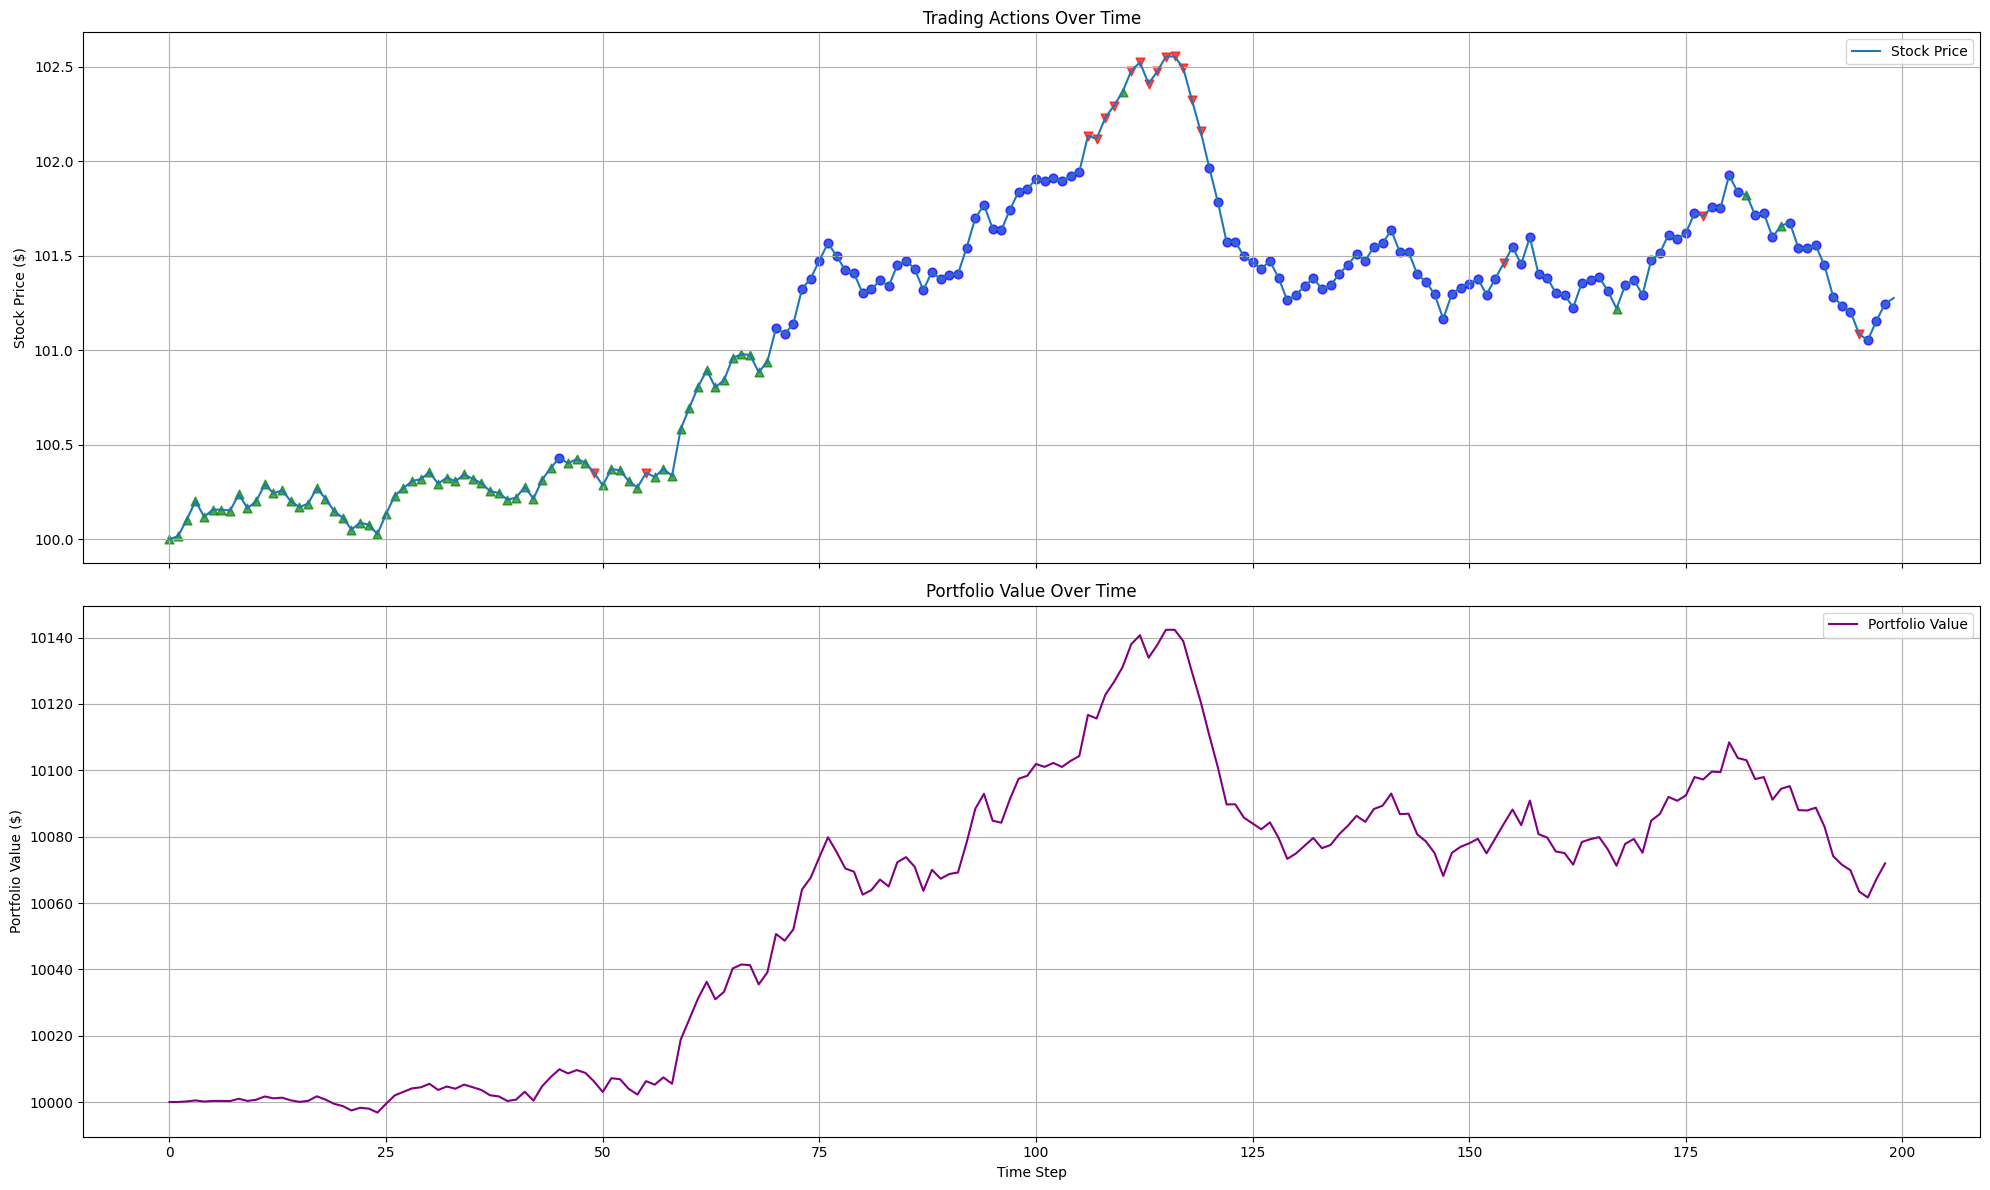

In [56]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# First subplot: Stock Price and Actions
ax1.plot(prices, label='Stock Price')
for idx, (action, price) in enumerate(zip(actions, prices[:len(actions)])):
    alpha = action_alphas[action]
    ax1.scatter(idx, price, color=action_colors[action], marker=action_markers[action], s=40, alpha=alpha)
ax1.set_title('Trading Actions Over Time')
ax1.set_ylabel('Stock Price ($)')
ax1.legend()
ax1.grid(True)

# Second subplot: Portfolio Value
ax2.plot(portfolio_values, label='Portfolio Value', color='purple')
ax2.set_title('Portfolio Value Over Time')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Portfolio Value ($)')
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## Next Steps

- **Enhance the Agent**: Incorporate more sophisticated decision-making in your agent to improve trading performance.
- **Include Transaction Costs**: Add realism by considering fees or slippage in your trading environment.
- **Expand State Representation**: Use additional market indicators or historical data to inform the agent's decisions.
- **Experiment with Other RL Algorithms**: Try algorithms like Deep Q-Networks (DQNs) for function approximation in larger state spaces.